# SKN 19기 mini-project 5팀(팀명: 여권어디있지) M/L

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# pandas 출력 옵션
pd.set_option('display.float_format', '{:.2f}'.format)

# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [4]:
# df_listings.info()

In [5]:
df_listings = pd.read_csv('./data/listings.csv')

In [6]:
df_listings.head(5)

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,number_of_reviews,first_review,review_scores_rating
0,Bunkyo Ku,Entire rental unit,Entire home/apt,3,1.00,0.00,2.00,"[""Bidet"", ""Body soap"", ""Bed linens"", ""Hot wate...",100000.00,0,NaN,NaN
1,Bunkyo Ku,Entire rental unit,Entire home/apt,8,1.00,2.00,5.00,"[""Bidet"", ""Body soap"", ""Bed linens"", ""Hot wate...",100000.00,0,NaN,NaN
2,Taito Ku,Entire serviced apartment,Entire home/apt,4,2.00,2.00,2.00,"[""Room-darkening shades"", ""Body soap"", ""Carbon...",14550.00,24,2023-12-04,4.42
3,Kita Ku,Entire home,Entire home/apt,8,1.00,3.00,6.00,"[""Room-darkening shades"", ""Cooking basics"", ""C...",22012.00,15,2024-01-10,4.73
4,Sumida Ku,Entire rental unit,Entire home/apt,3,1.00,1.00,1.00,"[""Clothing storage: closet"", ""Elevator"", ""Hair...",15429.00,17,2023-12-26,5.00


In [7]:
# from sklearn.preprocessing import OneHotEncoder
# oh_enc = OneHotEncoder(sparse_output=False)
# oh_enc.fit(df_listings[['neighbourhood_cleansed']])
# encoded_array = oh_enc.transform(df_listings[['neighbourhood_cleansed']])
# feature_names = oh_enc.get_feature_names_out(['neighbourhood_cleansed'])
# encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df_listings.index)
# df_listings = pd.concat([df_listings.drop('neighbourhood_cleansed', axis=1), encoded_df], axis=1)

In [8]:
# # 원래 컬럼을 제외하고 더미 변수 생성 후 합치기
# df_listings = pd.concat([
#     df_listings.drop('neighbourhood_cleansed', axis=1), 
#     pd.get_dummies(df_listings['neighbourhood_cleansed'], prefix='neighbourhood')
# ], axis=1)

In [9]:
# neighbourhood_price_mean = df_listings.groupby('neighbourhood_cleansed')['price'].mean()
# df_listings['neighbourhood_cleansed'] = df_listings['neighbourhood_cleansed'].map(neighbourhood_price_mean)


def target_encode(df, column_name):
    col_mean = df.groupby(column_name)['price'].mean()
    return df[column_name].map(col_mean)


# neighbourhood_cleansed	property_type	room_type

df_listings['neighbourhood_cleansed_te'] = target_encode(df_listings,'neighbourhood_cleansed')
df_listings['property_type_te'] = target_encode(df_listings,'property_type')
df_listings['room_type_te'] = target_encode(df_listings,'room_type')

In [10]:
from sklearn.preprocessing import LabelEncoder


df_listings['neighbourhood_cleansed_le'] = LabelEncoder().fit_transform(df_listings['neighbourhood_cleansed'])
df_listings['property_type_le'] = LabelEncoder().fit_transform(df_listings['property_type'])
df_listings['room_type_le'] = LabelEncoder().fit_transform(df_listings['room_type'])

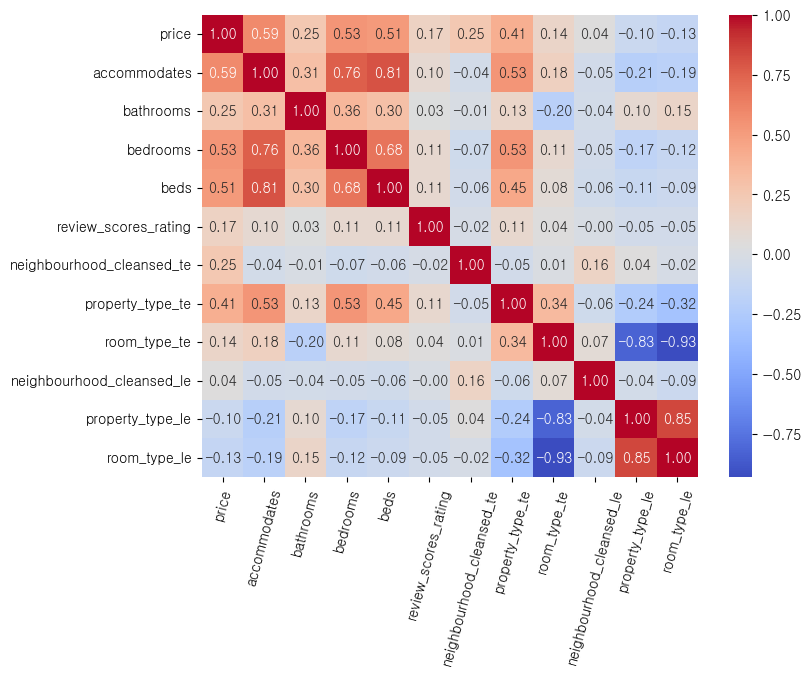

In [11]:
heat_map_columns = [
        'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating',
        'neighbourhood_cleansed_te','property_type_te', 'room_type_te',
        'neighbourhood_cleansed_le','property_type_le', 'room_type_le'
        ]

# 상관계수 히트맵
heat_map_corr = df_listings[heat_map_columns].corr()
plt.figure(figsize=(8,6))
sns.heatmap(heat_map_corr, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("상관계수 히트맵 : 로그화된 리뷰 수 컬럼과 가격의 상관 관계 분석")
plt.xticks(rotation=75) 
plt.show()


# 비선형적 관계에서는 히트맵이 잘 안나온다.
# 타겟 인코딩은 히트맵에서 관계가 잘 나올 수 밖에 없다.

In [12]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23007 entries, 0 to 23006
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     23007 non-null  object 
 1   property_type              23007 non-null  object 
 2   room_type                  23007 non-null  object 
 3   accommodates               23007 non-null  int64  
 4   bathrooms                  23007 non-null  float64
 5   bedrooms                   23007 non-null  float64
 6   beds                       23007 non-null  float64
 7   amenities                  23007 non-null  object 
 8   price                      23007 non-null  float64
 9   number_of_reviews          23007 non-null  int64  
 10  first_review               19875 non-null  object 
 11  review_scores_rating       19875 non-null  float64
 12  neighbourhood_cleansed_te  23007 non-null  float64
 13  property_type_te           23007 non-null  flo